In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from _code.feature_extraction import bandpass
import pickle
from scipy.signal import butter, sosfiltfilt

FS = 250

In [12]:
# Trial Data
# task_data = pd.read_csv('../eventide_data/manumm/BaseReport_Manu_2.csv', skiprows=8, index_col=None)
task_data = pd.read_csv('../eventide_data/manumm/BaseReport.csv', skiprows=8, index_col=None)
task_data.rename(columns={"Trial Number" : 'trial number', "Hand Condition": 'condition'}, inplace=True)
# task_data['condition'] = task_data['condition'].str.rstrip("'")
# task_data['trial number'] = task_data['trial number'].str.strip("'")

# Extract the condition list
trial_condition = np.array(task_data['condition'].apply(int))

# Read the raw data
raw_data = pd.read_csv('../eventide_data/manumm/SignalData_Manu-MM.csv', delimiter='\t', skiprows=1)
# raw_data = pd.read_csv('../eventide_data/manumm/SignalData_Manu_2.csv', delimiter='\t', skiprows=1)
raw_data.reset_index(inplace=True)
new_data_cols = raw_data.columns
raw_data.columns = ['Timestamp', 'Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 
                    'Fz', 'Cz', 'Pz', 'Hardware timestamp', 'marker', 'marker time', 'marker type', 'bs1']

# raw_data.columns = ['Timestamp', 'Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 
#                     'Fz', 'Cz', 'Pz',  'marker', 'marker time', 'marker type', 'bs1']

# Get the indices for start and finish
task_start_index = raw_data[raw_data['marker type'].isin(['trial'])].index
task_end_index = raw_data[raw_data['marker type'].isin(['Pause'])].index

trial_data ={
    'cl1' : [],
    'cl2' : [],
}

for trial, (start, end, _class) in enumerate(zip(task_start_index, task_end_index, trial_condition)):
    interval = raw_data[start:end]
    interval = interval.drop(columns=['Timestamp', 'Hardware timestamp', 'bs1', 'marker', 'marker time', 'marker type'])
    # interval = interval.drop(columns=['Timestamp',  'bs1', 'marker', 'marker time', 'marker type'])
    interval.reset_index(drop=True, inplace=True)

    if _class == 0:
        trial_data['cl1'].append(interval[0:820])
    else:
        trial_data['cl2'].append(interval[0:820])




In [81]:
with open('../eventide_data/manu_mm_1.pickle', 'rb') as f:
    base_report_one, raw_data_one = pickle.load(f)

    task_start_index = raw_data[raw_data['marker type'].isin(['trial'])].index
    task_end_index = raw_data[raw_data['marker type'].isin(['Pause'])].index

with open('../eventide_data/manu_mm_2.pickle', 'rb') as f:
    base_report_two, raw_data_two = pickle.load(f)

cl1 = 'class 1'
cl2 = 'class 2'

trials_raw = {
    cl1: [],
    cl2: [],
}

trials_filt = {
    cl1: [],
    cl2: [],
}

lower_bound = 0
upper_bound = 820

for base_report, raw_data in [(base_report_one, raw_data_one), (base_report_two, raw_data_two)]:
    task_start_index = raw_data[raw_data['marker type'].isin(['trial'])].index
    task_end_index = raw_data[raw_data['marker type'].isin(['Pause'])].index
    trial_condition = np.array(base_report['condition'].apply(int))

    sos = butter(N=2, Wn=[8, 15], btype='band', fs=250, output='sos')

    raw_data_filt = raw_data.drop(columns=['Timestamp',  'bs1', 'marker', 'marker time', 'marker type'])
    raw_data_filt = raw_data_filt.apply(lambda x: sosfiltfilt(sos, x), axis=0)

    for start, end, _class in zip(task_start_index, task_end_index, trial_condition):
        raw_interval= raw_data[start:end]
        filt_interval= raw_data_filt[start:end]

        raw_interval.reset_index(drop=True, inplace=True)
        filt_interval.reset_index(drop=True, inplace=True)

        if _class == 0:
            trials_raw[cl1].append(raw_interval[lower_bound:upper_bound])
            trials_filt[cl1].append(filt_interval[lower_bound:upper_bound])

        elif _class == 1:
            trials_raw[cl2].append(raw_interval[lower_bound:upper_bound])
            trials_filt[cl2].append(filt_interval[lower_bound:upper_bound])
        
channels = list(trials_filt[cl1][0].columns)

        
    

In [87]:
def get_trials_logvar(trials):
    trials_logvar = []
    for data_df in trials:
        logvar_df = data_df.apply(lambda x: np.log(x.var()), axis=0)
        trials_logvar.append(logvar_df)
    return trials_logvar

def bandpass(trials, lo, hi, sample_rate, filter_order=2):
    from scipy.signal import butter,  sosfiltfilt

    sos = butter(filter_order, [lo, hi], btype='band', fs=sample_rate, output='sos')

    # Applying the filter to each trial
    trials_filt = []
    for data_df in trials: 
        df_filt = data_df.apply(lambda x: sosfiltfilt(sos, x), axis=0)
        trials_filt.append(df_filt)
    return trials_filt


trials_logvar = {cl1: get_trials_logvar(trials_filt[cl1]),
                 cl2: get_trials_logvar(trials_filt[cl2])}

        


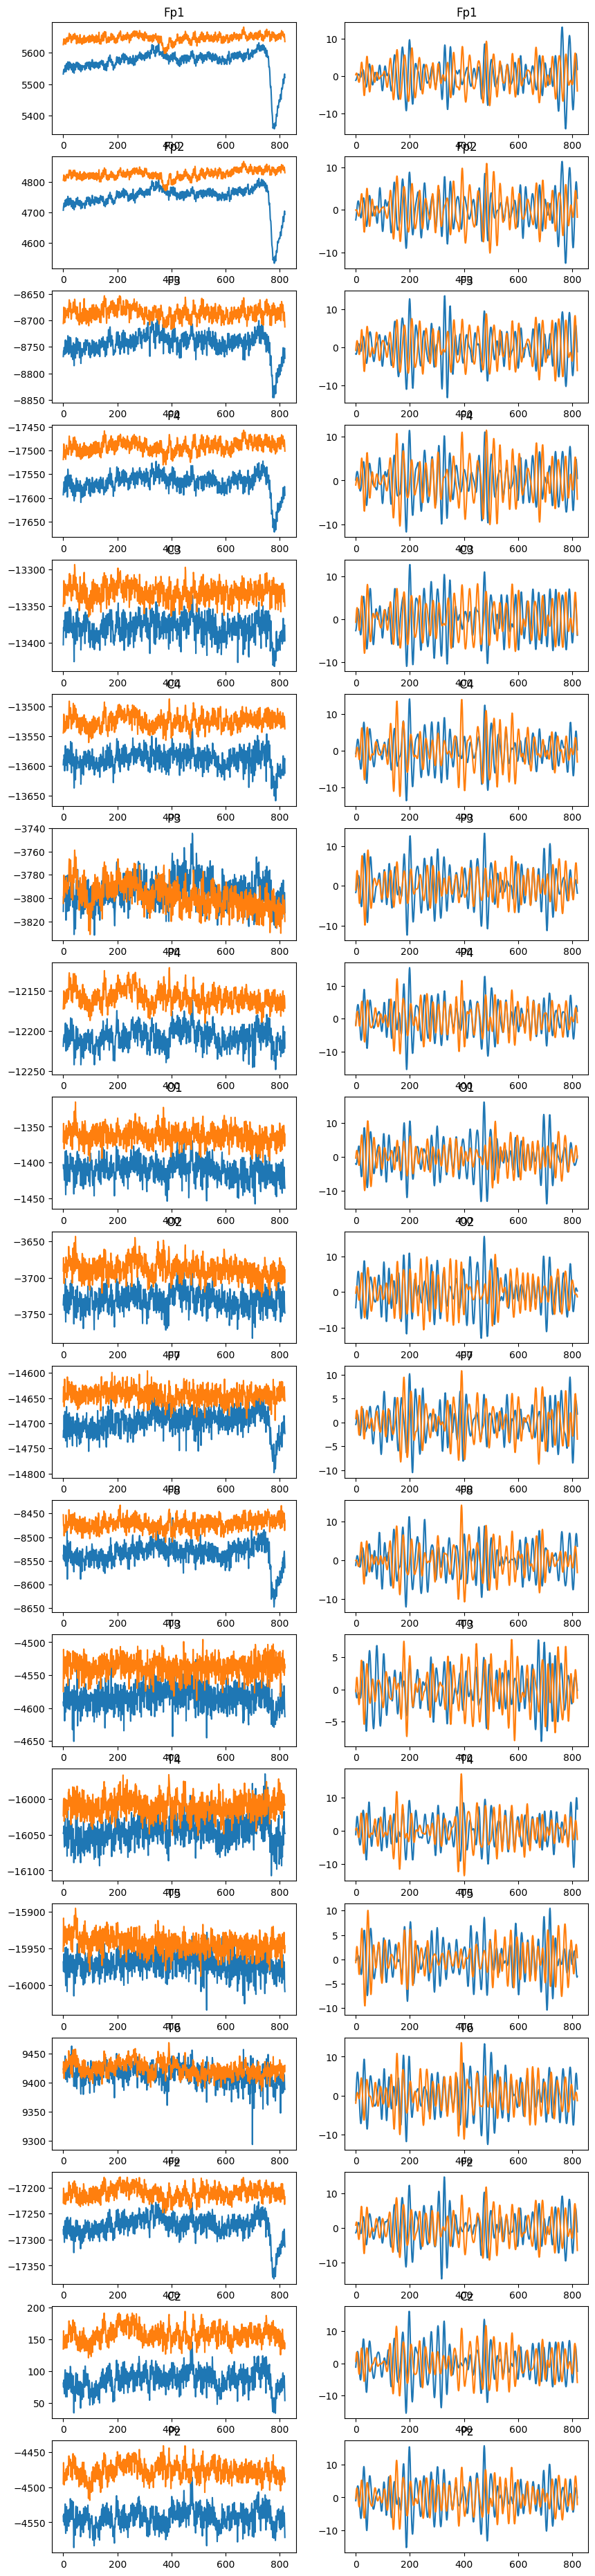

In [82]:
fig, axs = plt.subplots(len(channels), 2, figsize=(10, 2.5 *len(channels)))
trial_nr = 19

for i, channel in enumerate(channels):
    data_frag_cl1 = trials_raw[cl1][trial_nr][channel]
    data_frag_cl2 = trials_raw[cl2][trial_nr][channel]
    
    filt_data_frag_cl1 = trials_filt[cl1][trial_nr][channel]
    filt_data_frag_cl2 = trials_filt[cl2][trial_nr][channel]

    axs[i, 0].plot(data_frag_cl1)
    axs[i, 0].plot(data_frag_cl2)
    axs[i, 0].set_title(channel)

    axs[i, 1].plot(filt_data_frag_cl1)
    axs[i, 1].plot(filt_data_frag_cl2)
    axs[i, 1].set_title(channel)

    # if i == 3:
    #     break

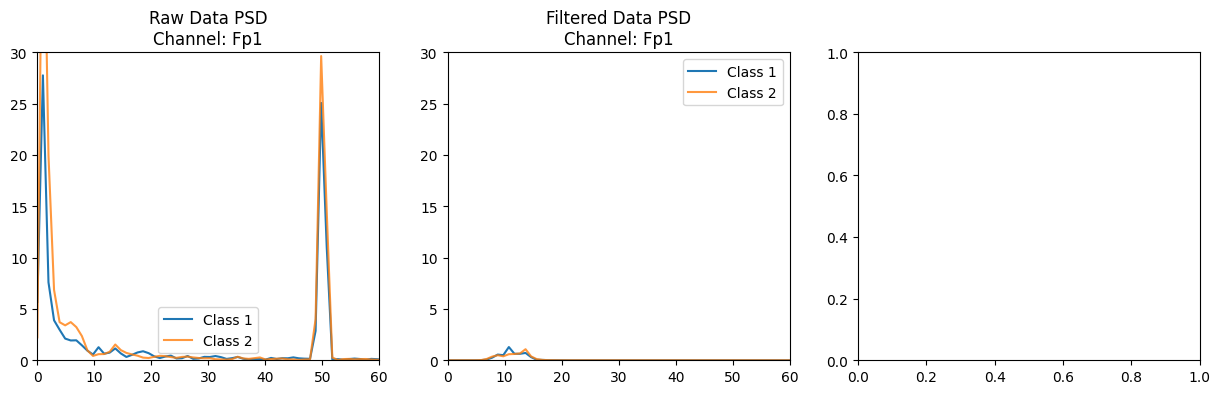

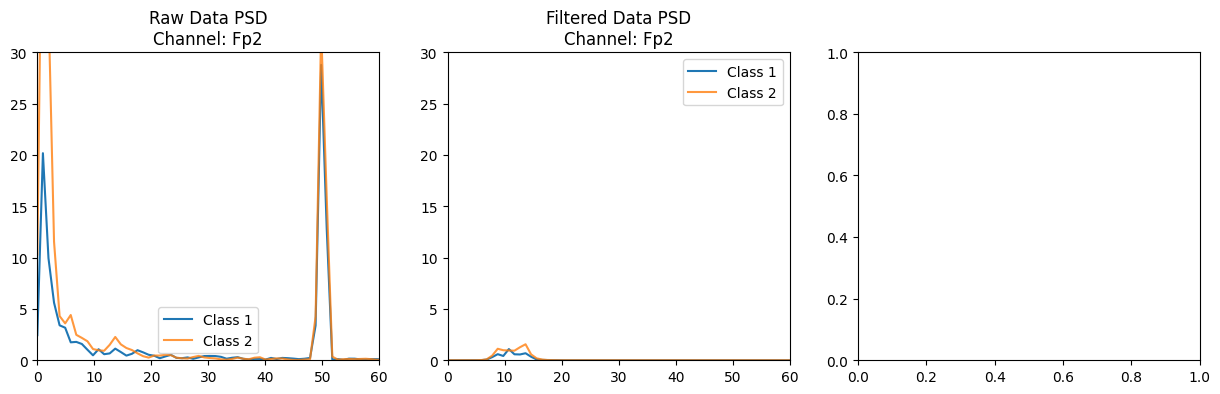

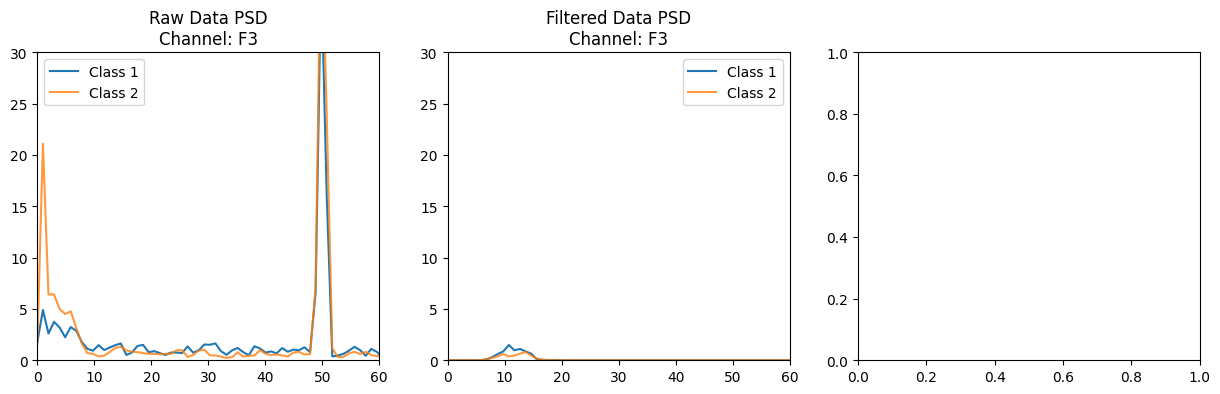

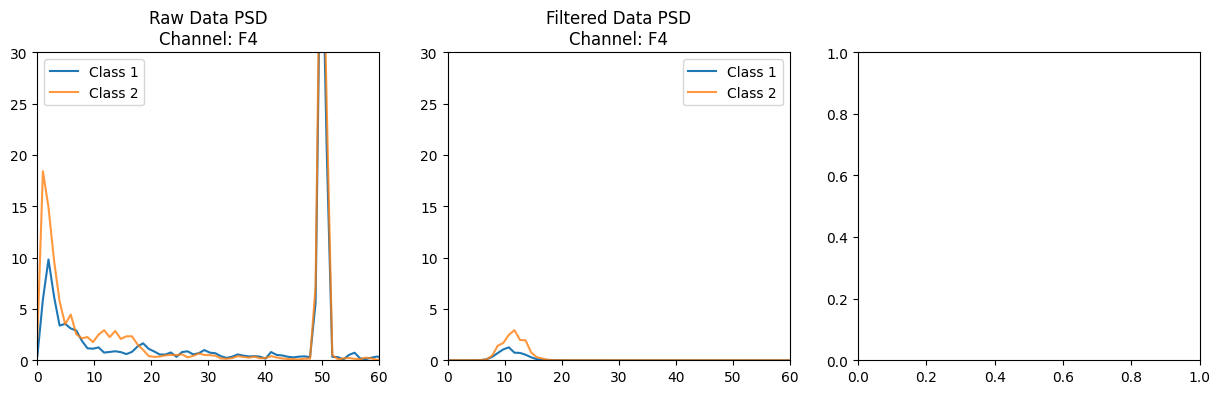

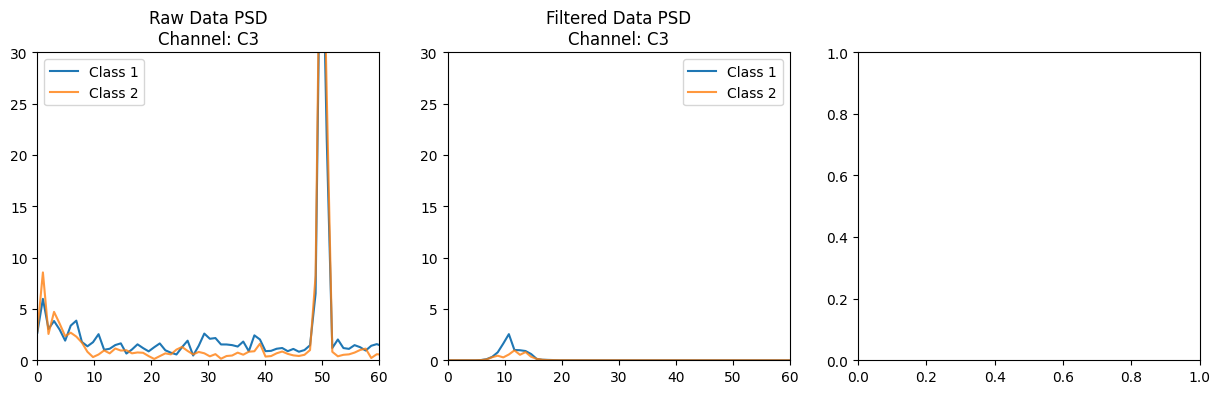

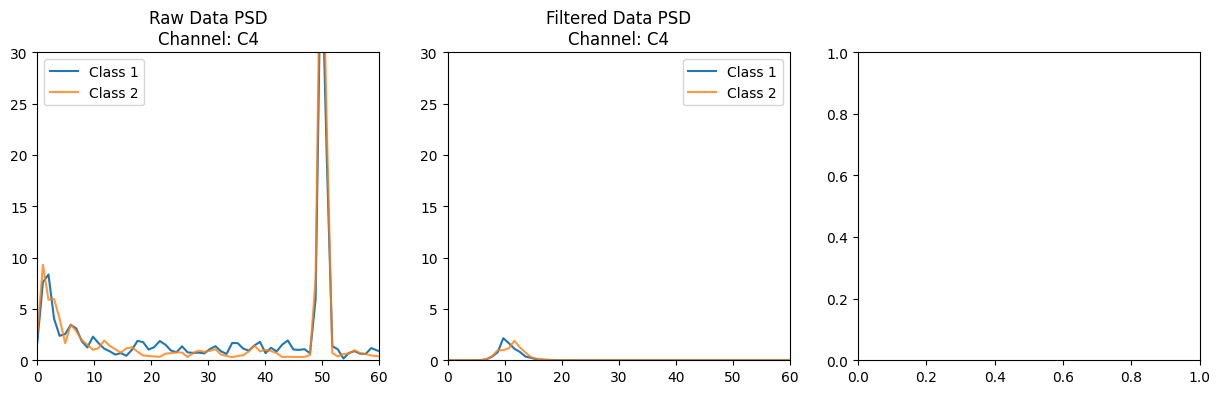

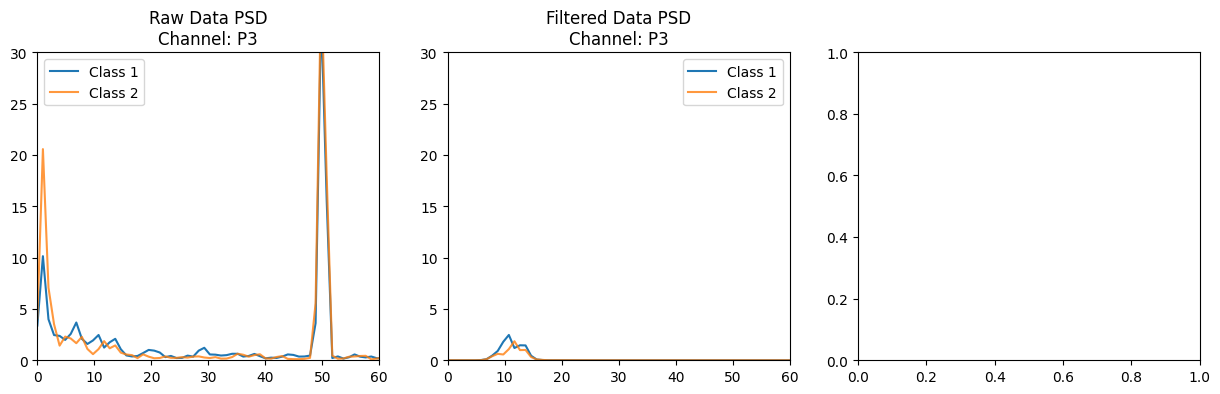

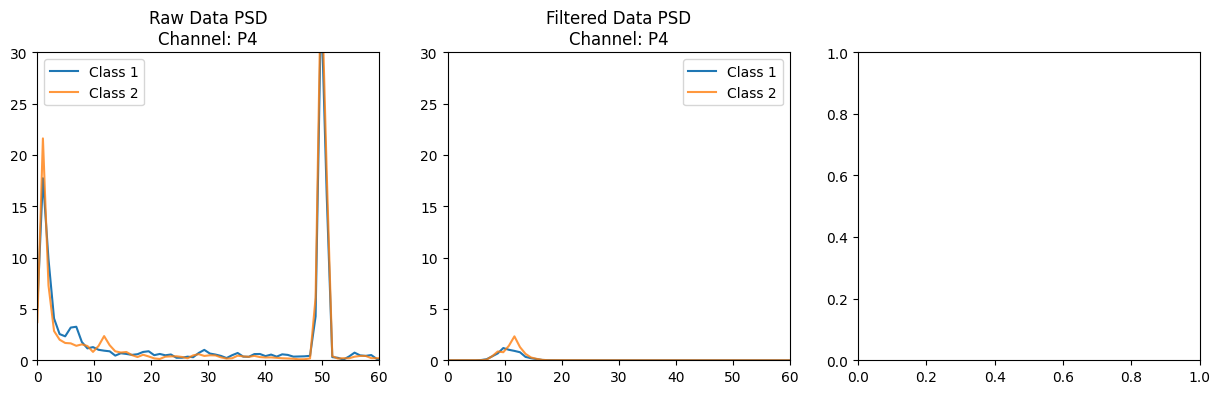

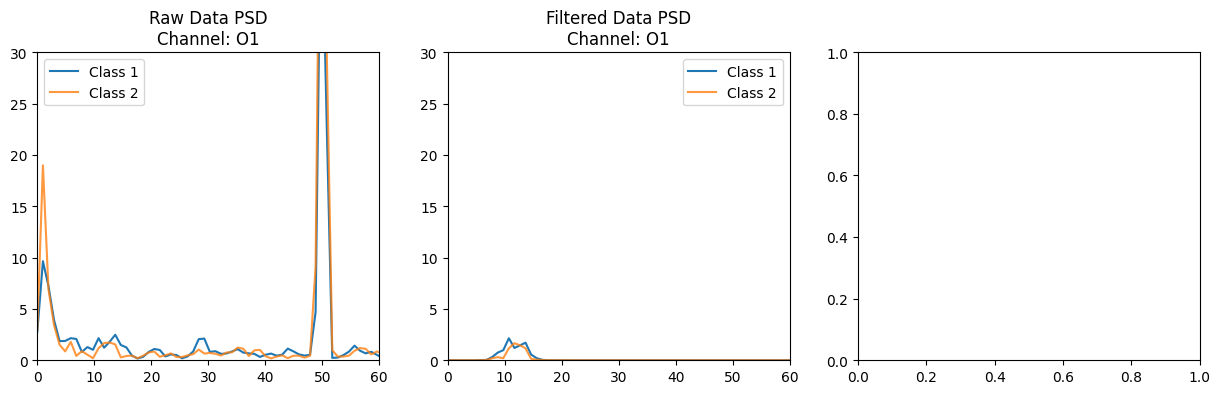

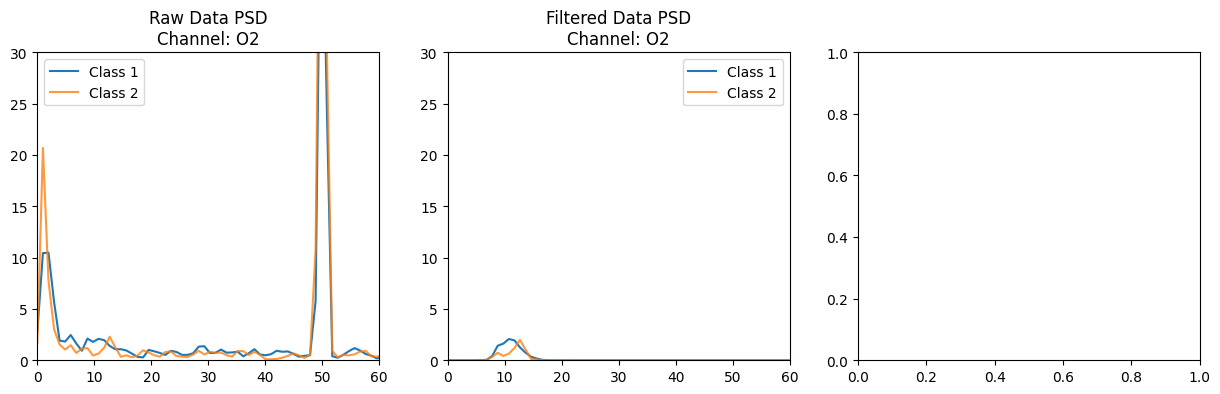

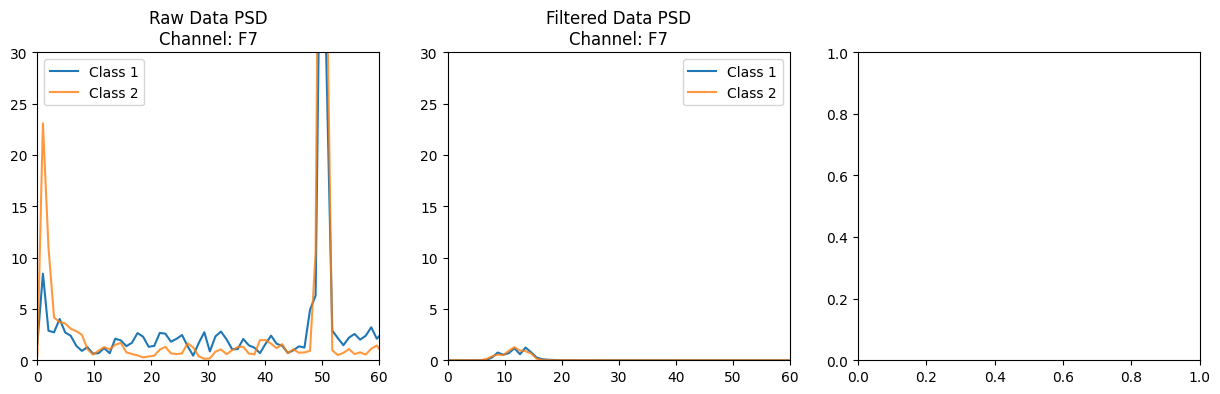

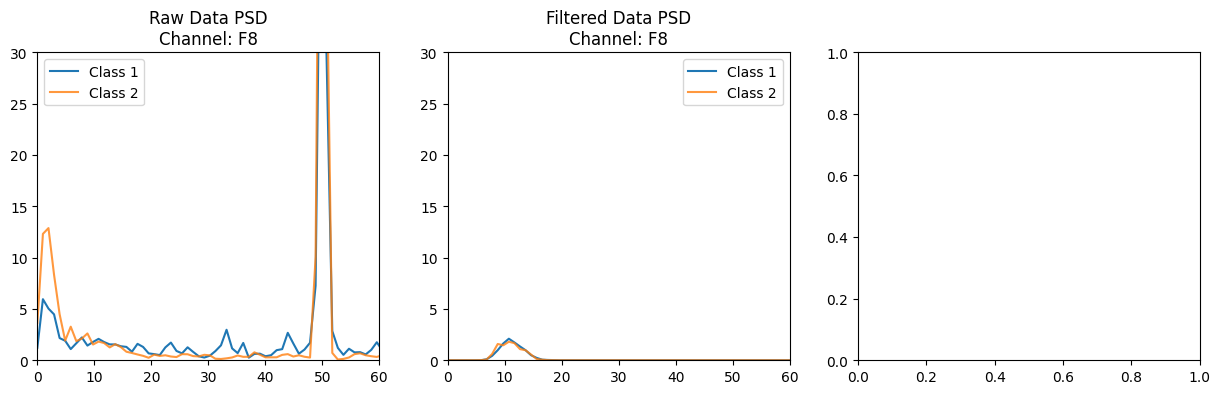

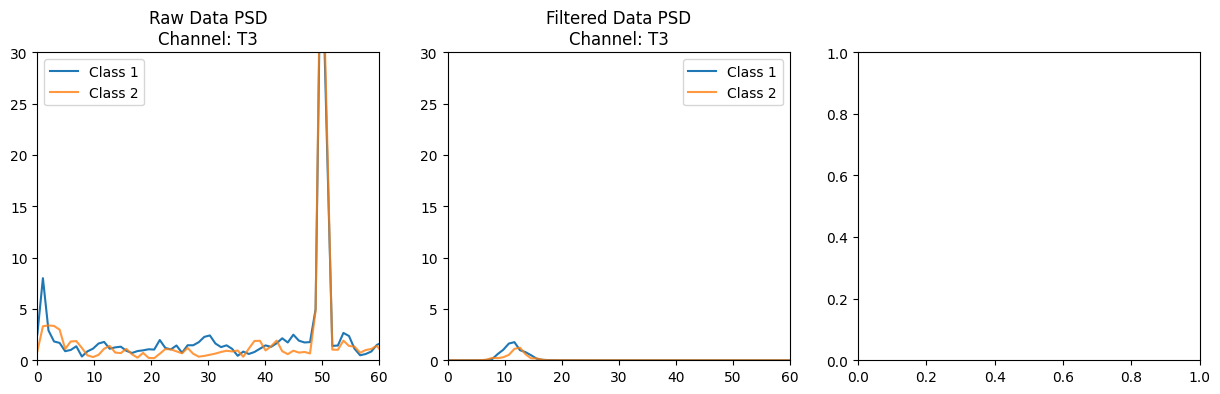

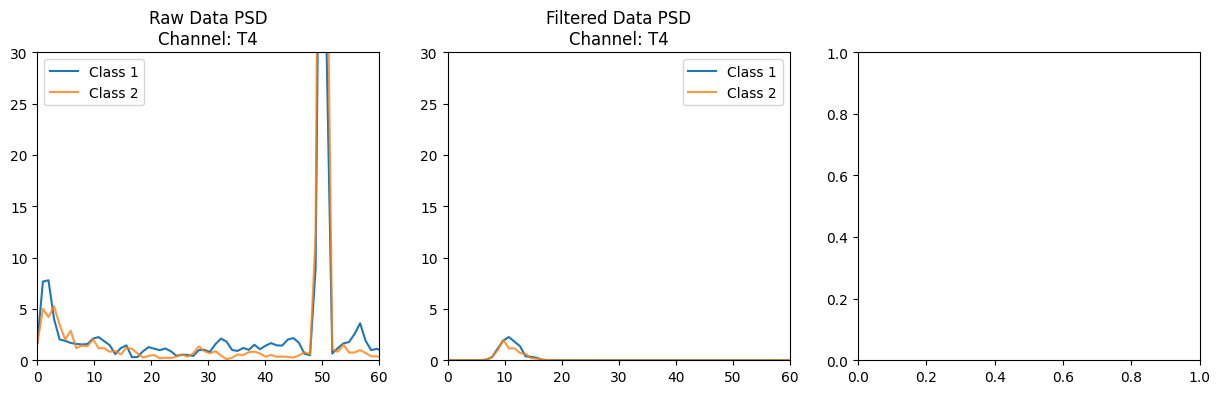

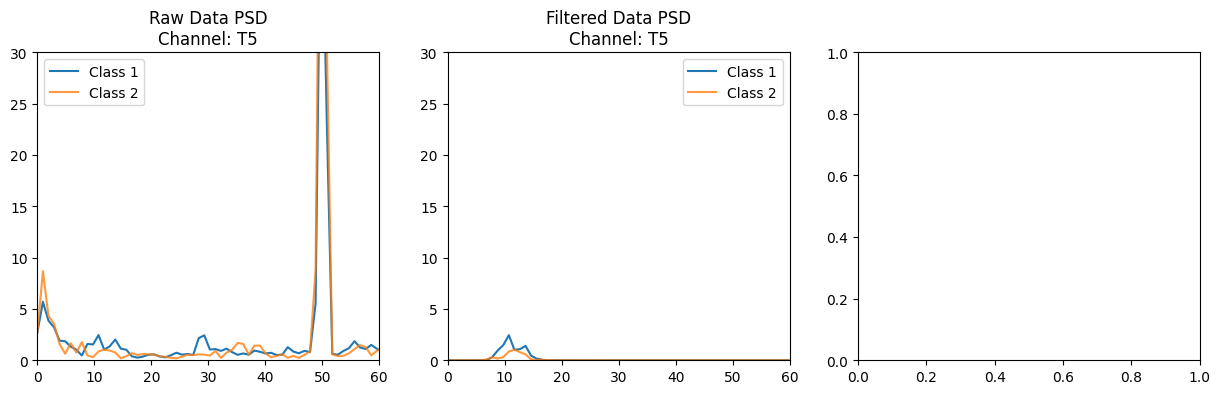

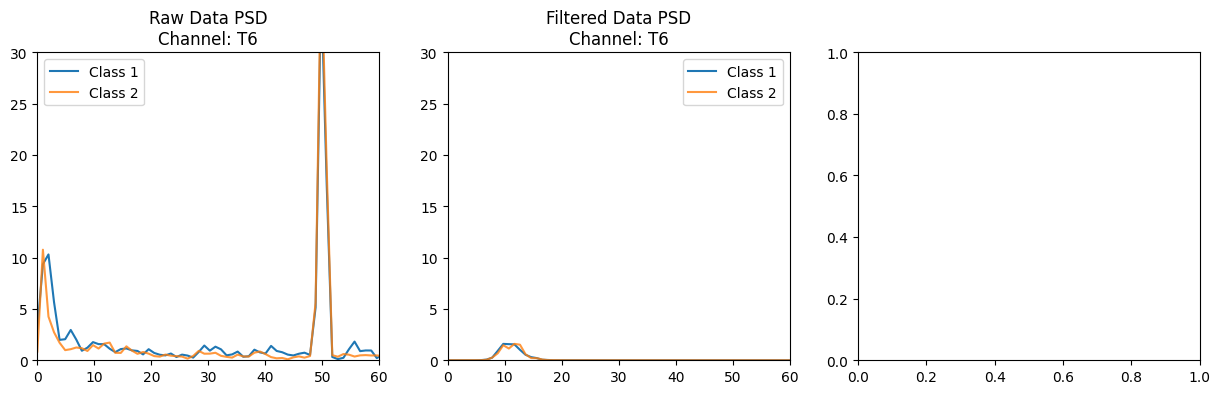

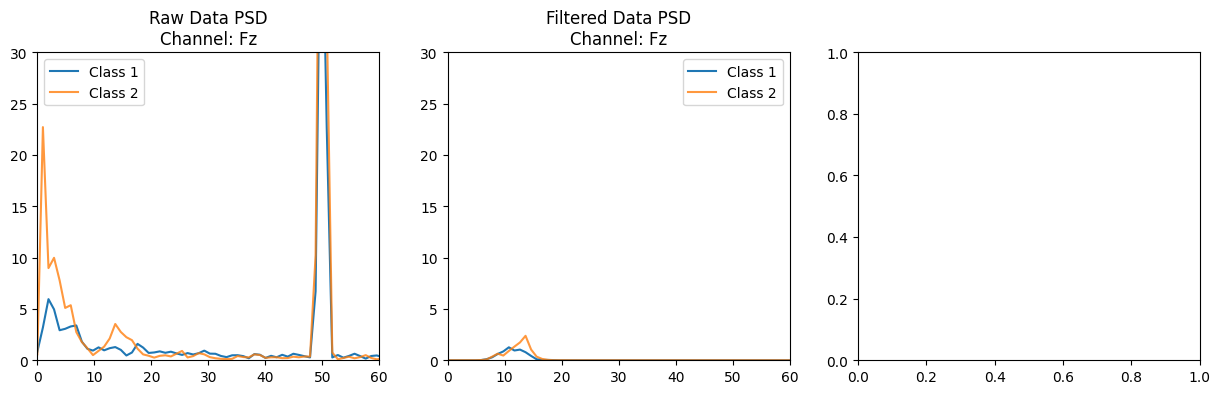

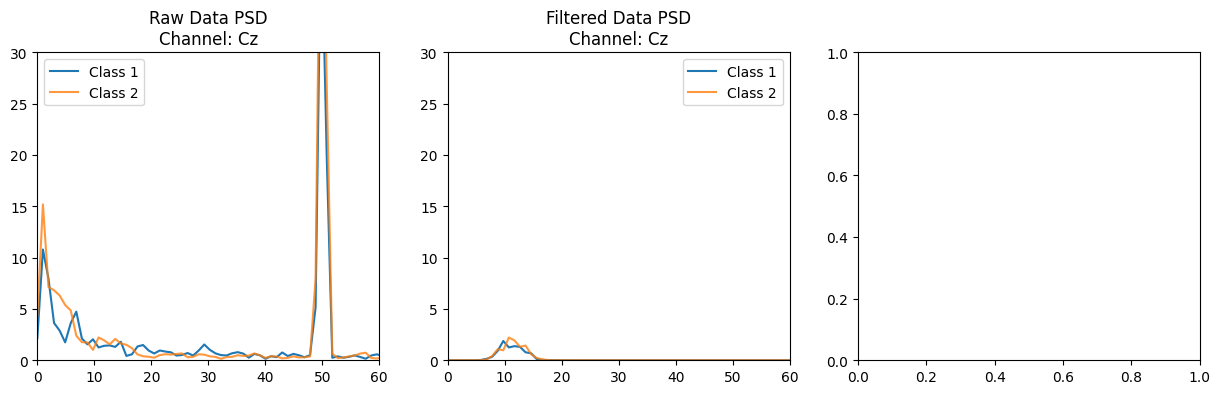

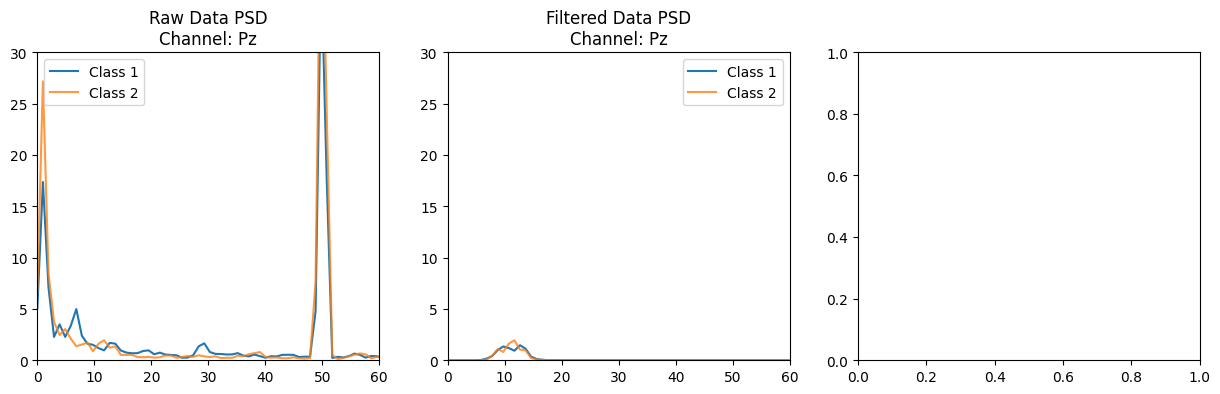

In [83]:
trial_number = 3

for channel in channels:
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # Plot Raw Data
    freqs, psd = signal.welch(trials_raw[cl1][trial_number][channel], FS)
    axes[0].plot(freqs, psd, label='Class 1')
    freqs, psd = signal.welch(trials_raw[cl2][trial_number][channel], FS)
    axes[0].plot(freqs, psd, label='Class 2', alpha=0.8)
    axes[0].set_title(f'Raw Data PSD\nChannel: {channel}')
    axes[0].legend()
    axes[0].set_xlim(0, 60)
    axes[0].set_ylim(0, 30)
    
    # Plot Filtered Data
    freqs, psd = signal.welch(trials_filt[cl1][trial_number][channel], FS)
    axes[1].plot(freqs, psd, label='Class 1')
    freqs, psd = signal.welch(trials_filt[cl2][trial_number][channel], FS)
    axes[1].plot(freqs, psd, label='Class 2', alpha=0.8)
    axes[1].set_title(f'Filtered Data PSD\nChannel: {channel}')
    axes[1].legend()
    axes[1].set_xlim(0, 60)
    axes[1].set_ylim(0, 30)

    i += 1
    # if i == 3:
    #     break


In [85]:
np.array([len(df) for df in trials_raw[cl1]])

array([820, 820, 820, 820, 820, 820, 820, 820, 820, 820, 820, 820, 820,
       820, 820, 820, 820, 820, 820, 820, 820, 820, 820, 820, 820, 820,
       820, 820, 820, 820, 820, 820, 820, 820, 820, 820, 820, 820, 820,
       820, 820, 820, 820, 820, 820, 820, 820, 820, 820, 820, 820, 820,
       820, 820, 820, 820, 820, 820, 820, 820, 820, 820, 820, 820, 820,
       820, 820, 820, 820, 820, 820, 820, 820, 820, 820, 820, 820, 820,
       820, 820, 820, 820, 820, 820, 820, 820, 820, 820, 820, 820, 820,
       820, 820, 820, 820, 820, 820, 820, 820, 820, 820, 820, 820, 820,
       820, 820, 820, 820, 820, 820, 820, 820, 820, 820, 820, 820, 820,
       820, 820, 820, 820, 820, 820, 820, 820, 820, 820, 820, 820, 820,
       820, 820, 820, 820, 820, 820, 820, 820, 820, 820])

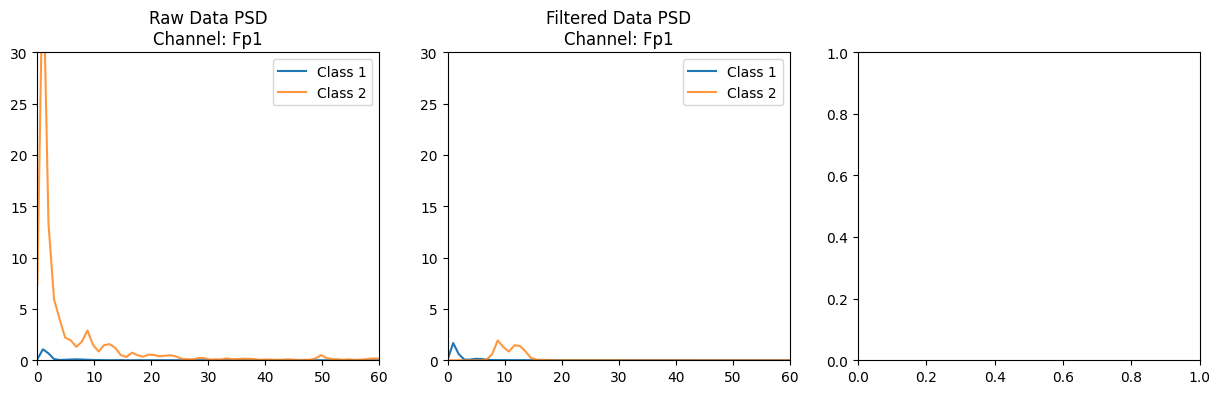

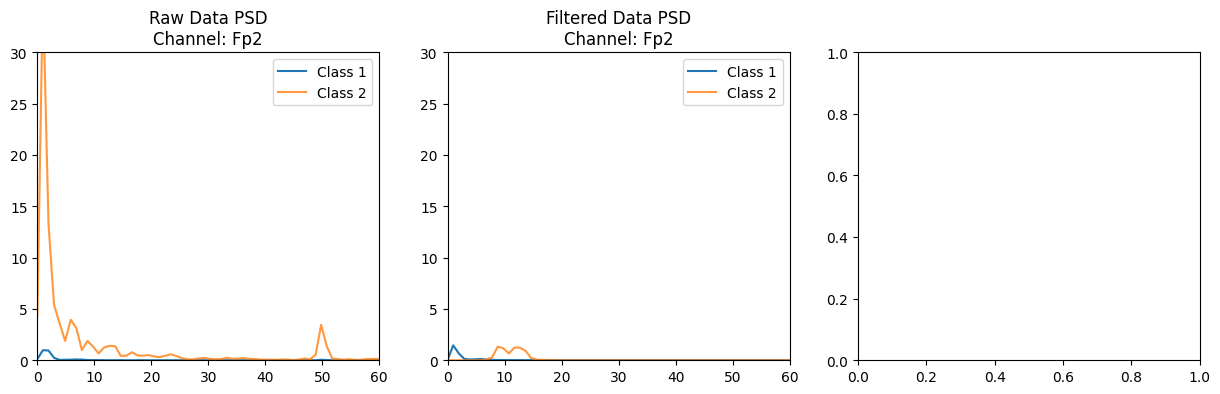

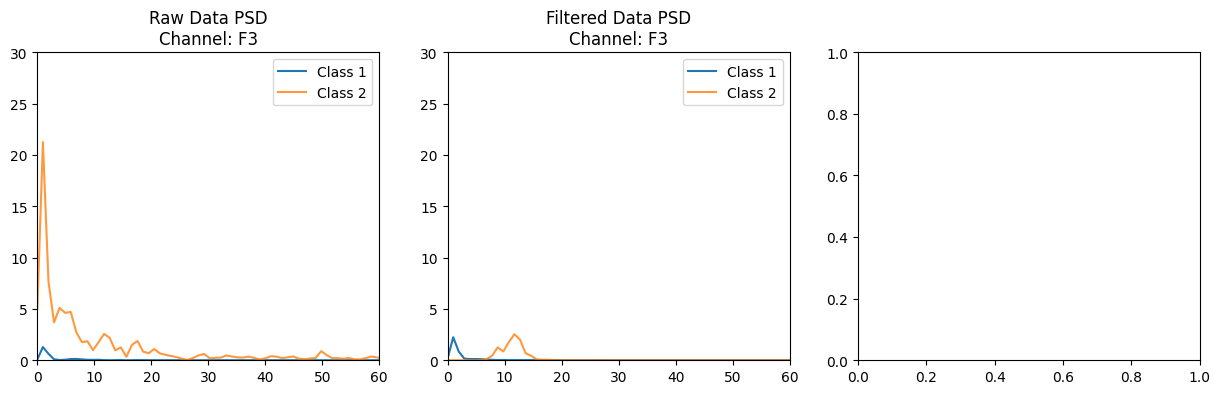

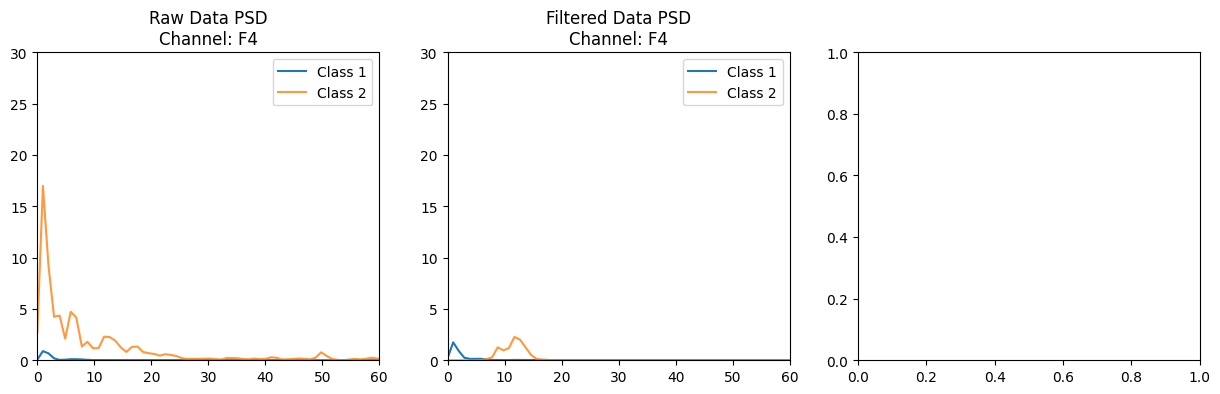

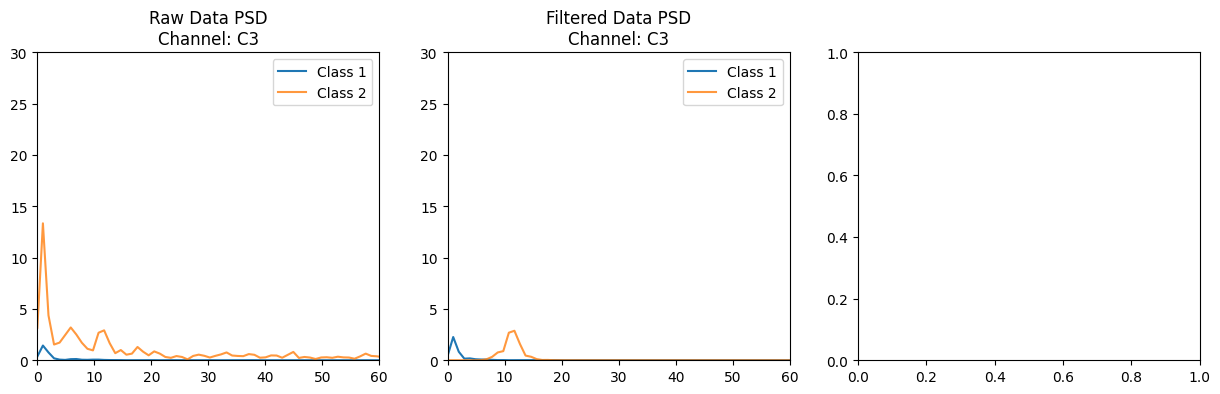

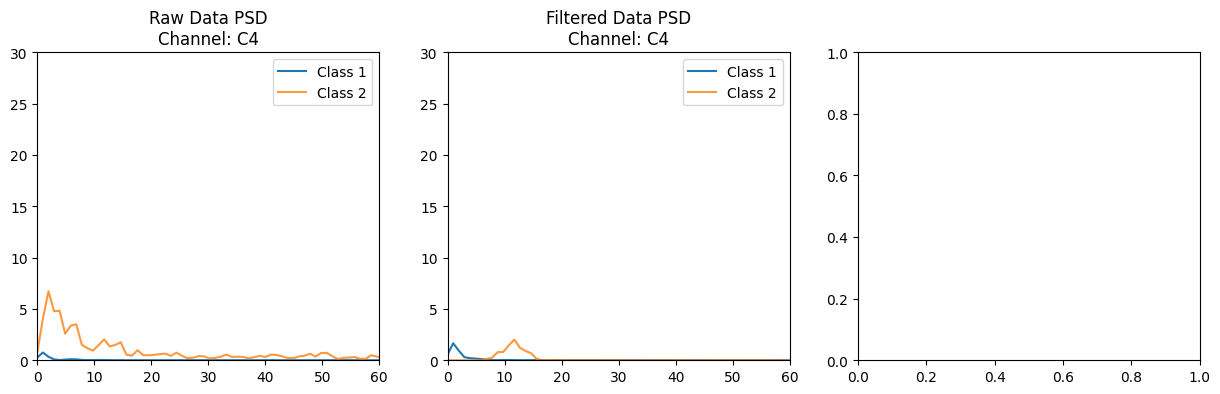

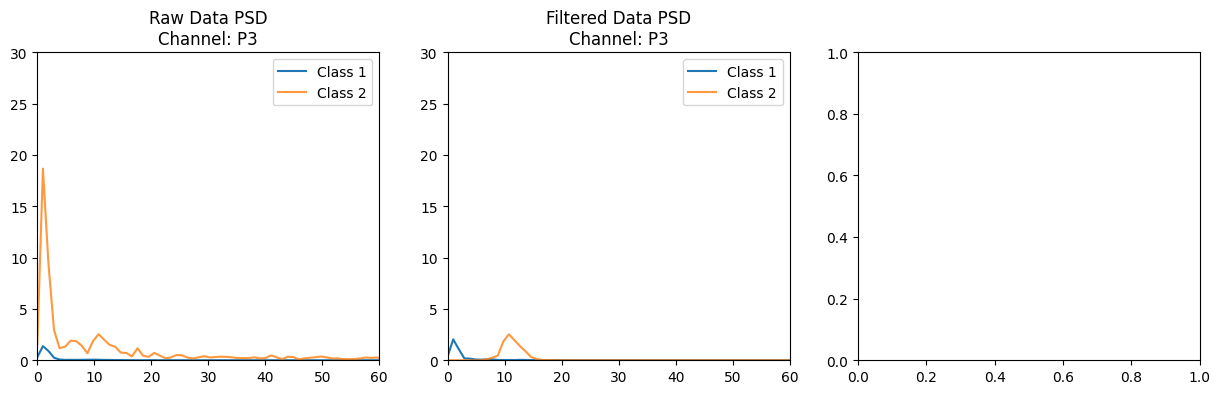

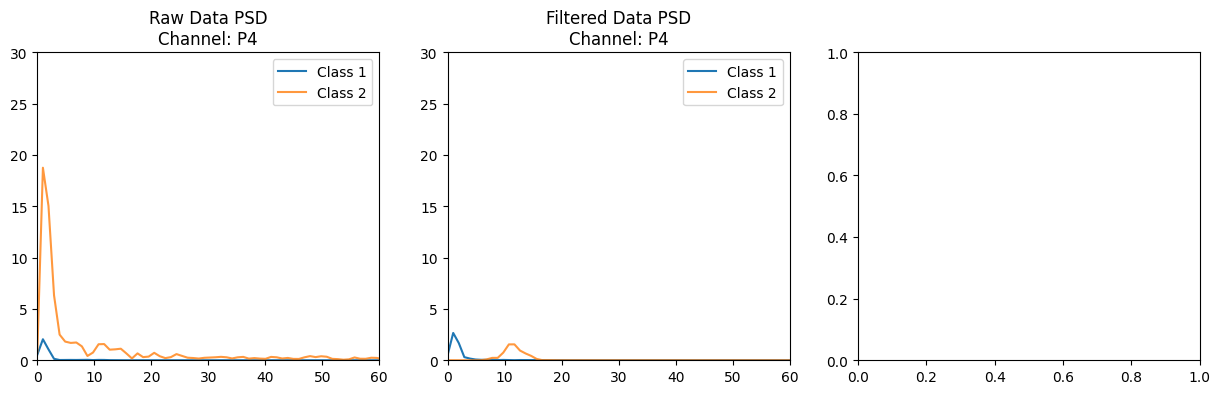

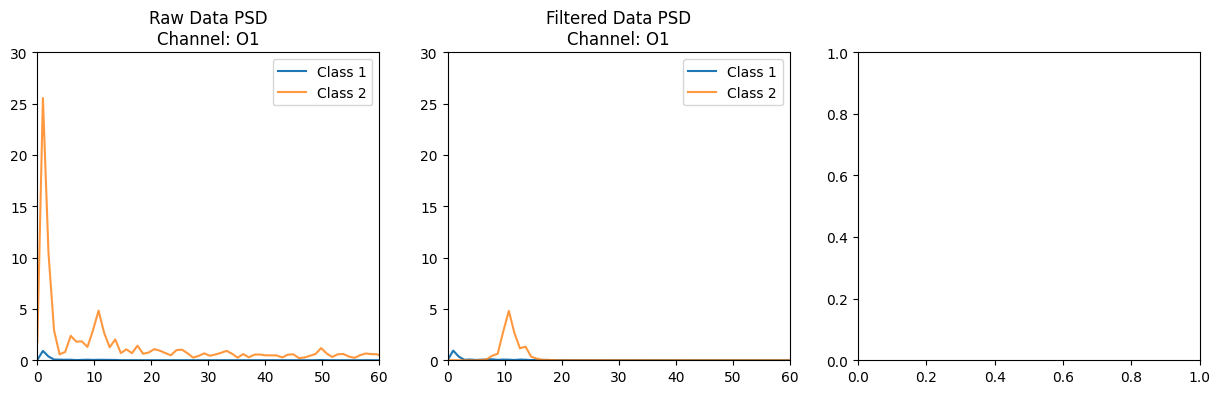

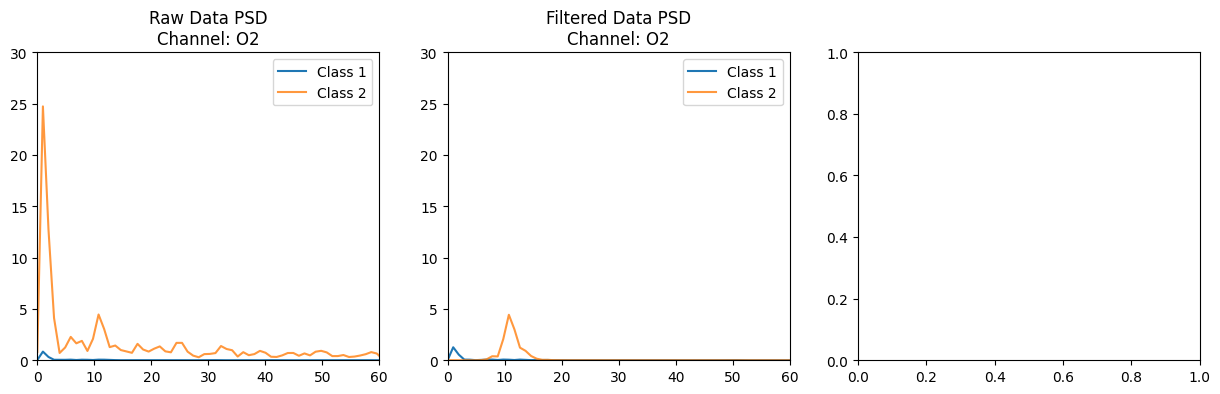

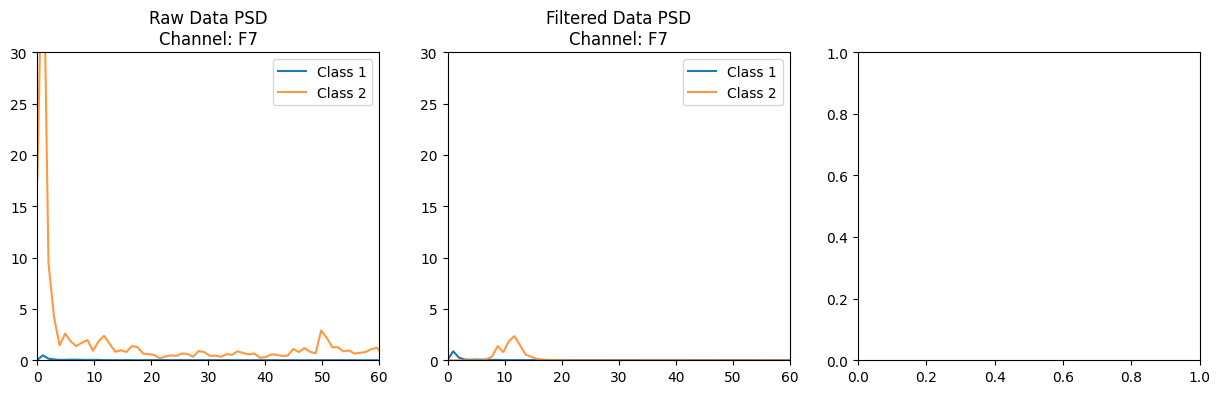

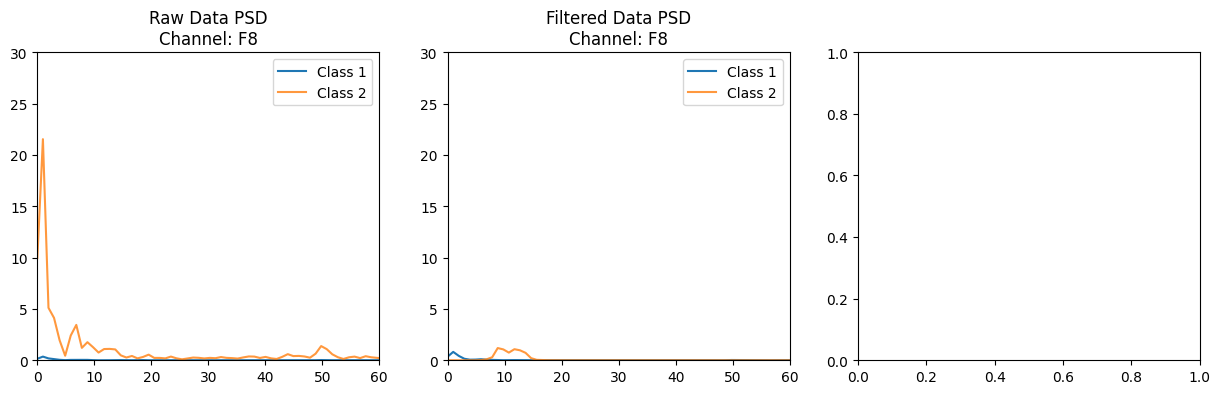

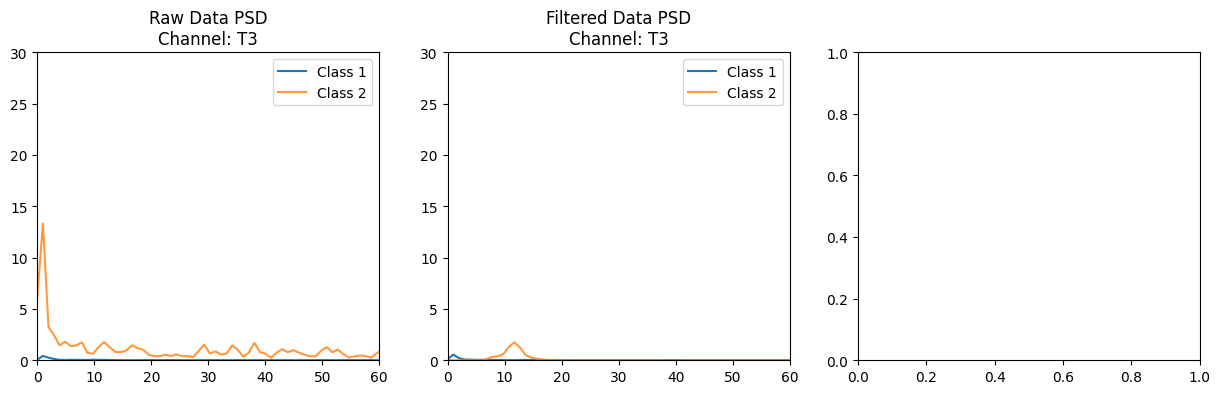

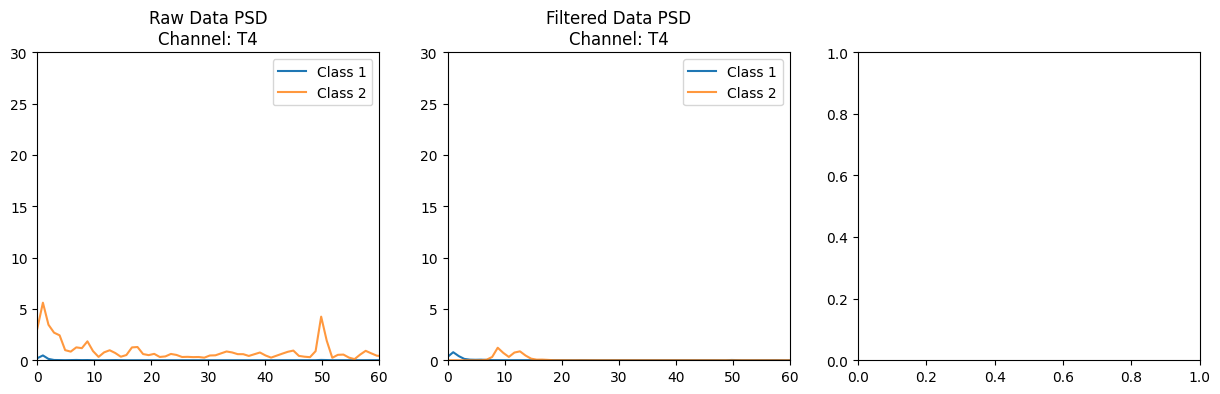

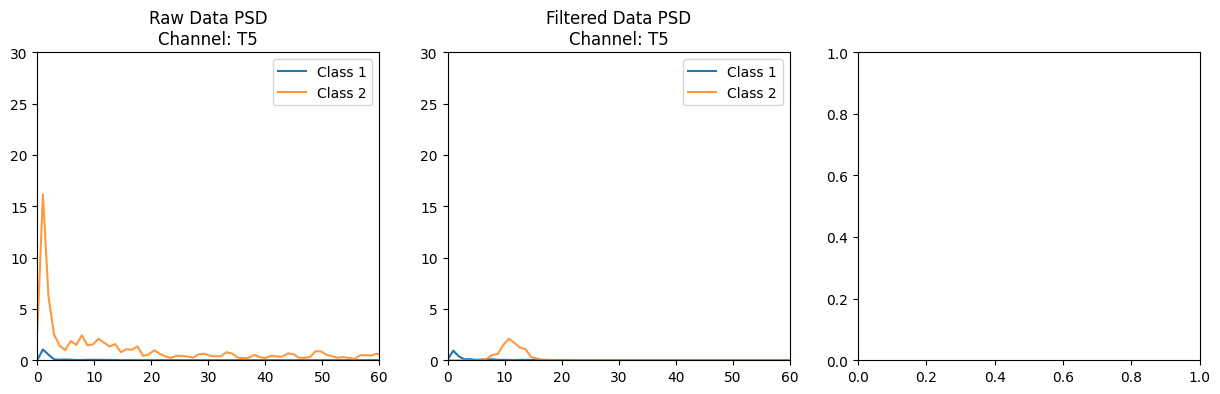

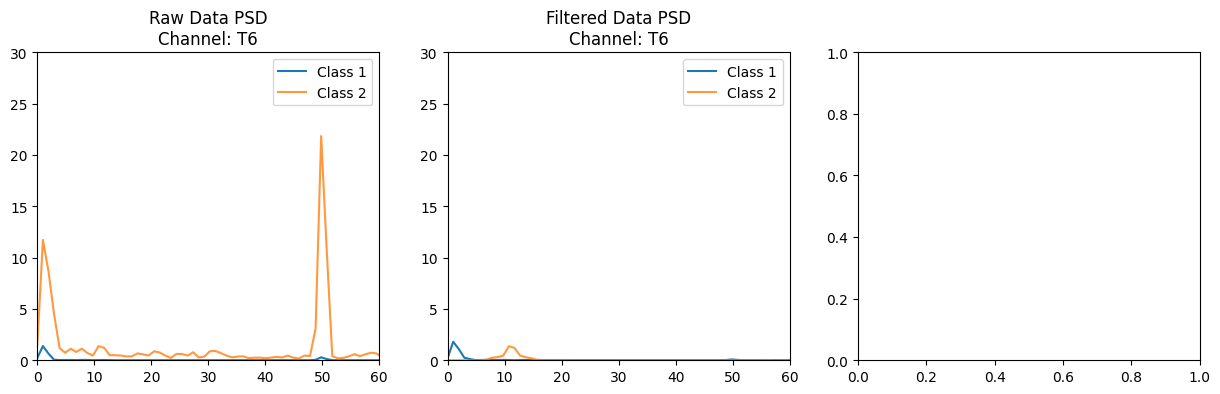

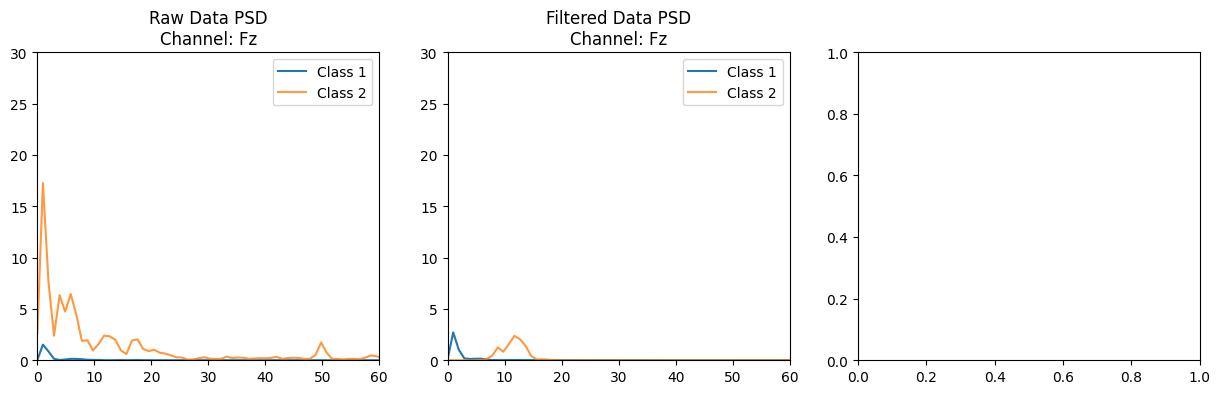

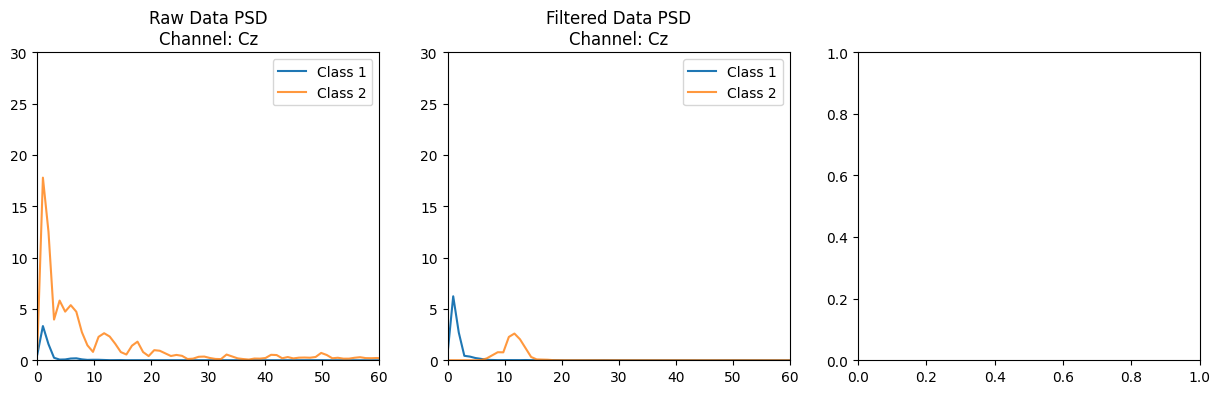

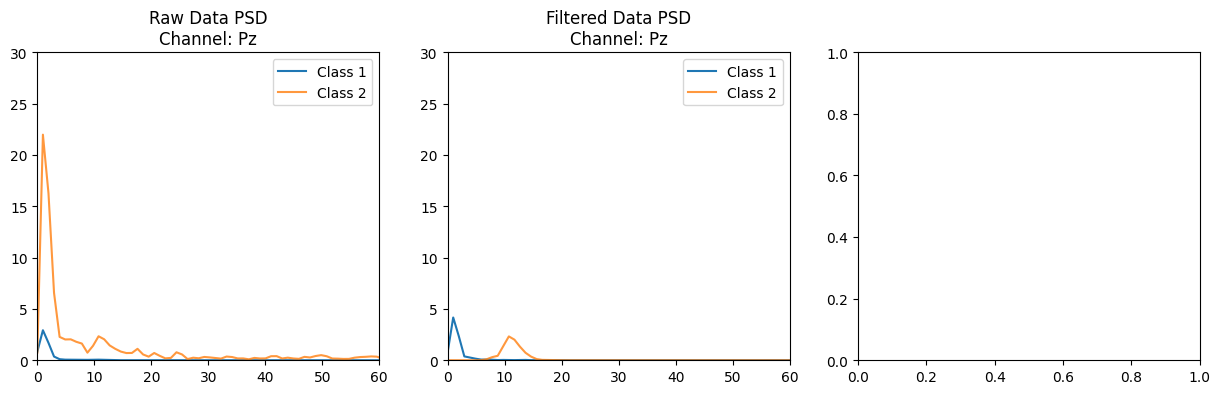

In [134]:
channels = trial_data['cl1'][0].columns.values
trial_number = 15

# For each channel calculate the PSD
i = 0
for channel in channels:
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # Plot Raw Data
    freqs, psd = signal.welch(np.mean(np.array([df[channel] for df in trial_data['cl1']]), axis=0), FS)

    axes[0].plot(freqs, psd, label='Class 1')
    freqs, psd = signal.welch(trial_data['cl2'][trial_number][channel], FS)
    axes[0].plot(freqs, psd, label='Class 2', alpha=0.8)
    axes[0].set_title(f'Raw Data PSD\nChannel: {channel}')
    axes[0].legend()
    axes[0].set_xlim(0, 60)
    axes[0].set_ylim(0, 30)
    
    # Plot Filtered Data
    freqs, psd = signal.welch(np.mean(np.array([df[channel] for df in trial_data['cl2']]), axis=0), FS)
    axes[1].plot(freqs, psd, label='Class 1')
    freqs, psd = signal.welch(trials_filt['cl2'][trial_number][channel], FS)
    axes[1].plot(freqs, psd, label='Class 2', alpha=0.8)
    axes[1].set_title(f'Filtered Data PSD\nChannel: {channel}')
    axes[1].legend()
    axes[1].set_xlim(0, 60)
    axes[1].set_ylim(0, 30)

    # i += 1
    # # if i == 3:
    # #     break


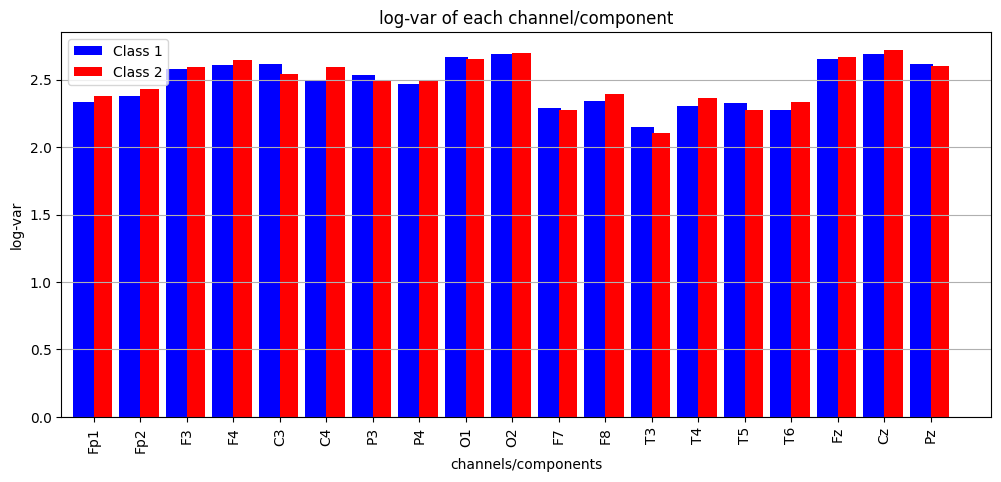

In [89]:

plt.figure(figsize=(12,5))
n_channels = len(channels)

x0 = np.arange(n_channels)
x1 = np.arange(n_channels) + 0.4

y0 = np.mean(np.array(trials_logvar[cl1]), axis=0)
y1 = np.mean(np.array(trials_logvar[cl2]), axis=0)

plt.bar(x0, y0, width=0.5, color='b', label='Class 1')
plt.bar(x1, y1, width=0.4, color='r', label='Class 2')

plt.xlim(-0.5, n_channels+0.5)

# The new ticks will be placed at the mid position of the two bars
bar_names = channels
xticks_positions = x0 + 0.2  
plt.xticks(xticks_positions, bar_names, rotation='vertical')

plt.gca().yaxis.grid(True)
plt.title('log-var of each channel/component')
plt.xlabel('channels/components')
plt.ylabel('log-var')
plt.legend()



In [158]:
from _code.feature_extraction import CSP

trials_filt_matrix = {}
trials_filt_matrix[cl1] = np.array(trials_filt[cl1]).transpose(2, 1, 0)
trials_filt_matrix[cl2] = np.array(trials_filt[cl2]).transpose(2, 1, 0)

csp = CSP(trials_filt_matrix[cl1], trials_filt_matrix[cl2])
trials_csp = {
    cl1 : csp(trials_filt_matrix[cl1]),
    cl2 : csp(trials_filt_matrix[cl2]),
    }

trials_logvar_csp = {
    cl1: np.log(np.var(trials_csp[cl1], axis=1)),
    cl2: np.log(np.var(trials_csp[cl2], axis=1))
    }



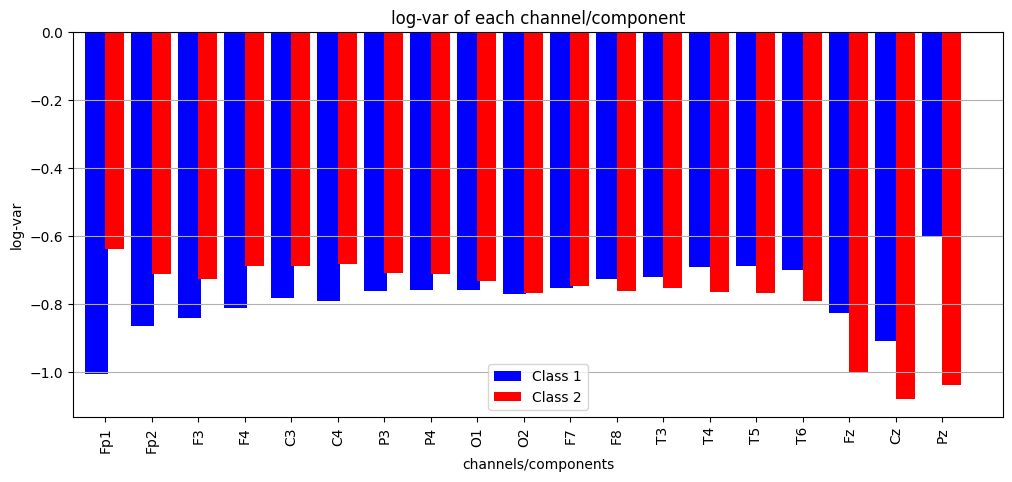

In [127]:
plt.figure(figsize=(12,5))
x0 = np.arange(n_channels)
x1 = np.arange(n_channels) + 0.4

y0 = np.mean(trials_logvar_csp[cl1], axis=1)
y1 = np.mean(trials_logvar_csp[cl2], axis=1)

plt.bar(x0, y0, width=0.5, color='b', label='Class 1')
plt.bar(x1, y1, width=0.4, color='r', label='Class 2')

plt.xlim(-0.5, n_channels+0.5)

# The new ticks will be placed at the mid position of the two bars
bar_names = list(trials_logvar[cl1][0].index)
xticks_positions = x0 + 0.2  
plt.xticks(xticks_positions, bar_names, rotation='vertical')

plt.gca().yaxis.grid(True)
plt.title('log-var of each channel/component')
plt.xlabel('channels/components')
plt.ylabel('log-var')
plt.legend()



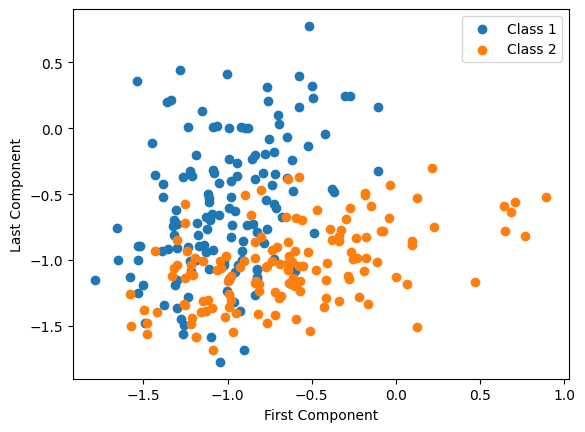

In [151]:
# Take the first and last component
a = 0
b = -1

trials_components = {
    cl1 : trials_logvar_csp[cl1][[a, b], :],
    cl2 : trials_logvar_csp[cl2][[a, b], :],
}

x, y = trials_components[cl1]
plt.scatter(x, y, label='Class 1')
x, y = trials_components[cl2]
plt.scatter(x, y, label='Class 2')
plt.xlabel('First Component')
plt.ylabel('Last Component')
plt.legend()

TypeError: cannot concatenate object of type '<class 'numpy.ndarray'>'; only Series and DataFrame objs are valid

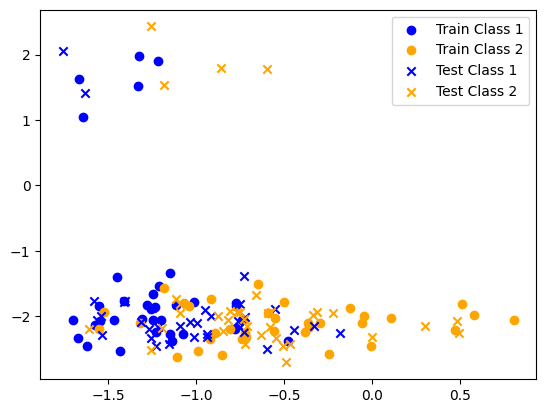

In [211]:
from sklearn.preprocessing import StandardScaler

a = 0
b = -1

range_train = range(70, 140, 2)
range_test = range(71, 140, 2)

x = {cl1: trials_filt_matrix[cl1][:,:,range_train],
     cl2: trials_filt_matrix[cl2][:,:,range_train]}

y = {cl1: trials_filt_matrix[cl1][:,:,range_test],
     cl2: trials_filt_matrix[cl2][:,:,range_test]}

csp = CSP(x[cl1], x[cl2])
comp = np.array([0, -1])



x[cl1] = csp(x[cl1])[comp,:,:]
x[cl2] = csp(x[cl2])[comp,:,:]
y[cl1] = csp(y[cl1])[comp,:,:]
y[cl2] = csp(y[cl2])[comp,:,:]

# Calculate the log-var
x[cl1] = np.log(np.var(x[cl1], axis=1))
x[cl2] = np.log(np.var(x[cl2], axis=1))
y[cl1] = np.log(np.var(y[cl1], axis=1))
y[cl2] = np.log(np.var(y[cl2], axis=1))

row, col = x[cl1]
plt.scatter(row, col, color='blue', label='Train Class 1')
row, col = x[cl2]
plt.scatter(row, col, color='orange', label='Train Class 2')
row, col = y[cl1]
plt.scatter(row, col, color='blue', marker='x', label='Test Class 1')
row, col = y[cl2]
plt.scatter(row, col, color='orange', marker = 'x', label='Test Class 2')
plt.legend()


scaler = StandardScaler()
scaler.fit(X_train) # compute the mean and standard deviation to be used for later scaling


In [ ]:
np.concatenate(x)

In [213]:
x.values()

# Assume df_dict is your dictionary of pandas DataFrames
df_dict = {
    "df1": pd.DataFrame({'A': ['A0', 'A1', 'A2', 'A3'],
                         'B': ['B0', 'B1', 'B2', 'B3'],
                         'C': ['C0', 'C1', 'C2', 'C3'],
                         'D': ['D0', 'D1', 'D2', 'D3']}),
    
    "df2": pd.DataFrame({'A': ['A4', 'A5', 'A6', 'A7'],
                         'B': ['B4', 'B5', 'B6', 'B7'],
                         'C': ['C4', 'C5', 'C6', 'C7'],
                         'D': ['D4', 'D5', 'D6', 'D7']})
}

# Concatenate the DataFrames along the row axis (default behavior)
df_concatenated = pd.concat(df_dict.values())

(2, 35)

In [131]:
# Splitting the frequency filtered signal into a train and test set
train = {cl1: trials_filt_matrix[cl1][:,:,0::2],
         cl2: trials_filt_matrix[cl2][:,:,:]}

test = {cl1: trials_filt_matrix[cl1][:,:,70:],
        cl2: trials_filt_matrix[cl2][:,:,70:]}

# Train the CSP on the training set only
csp = CSP(train[cl1], train[cl2])

# Apply the CSP on both the training and test set
train[cl1] = csp(train[cl1])
train[cl2] = csp(train[cl2])
test[cl1] = csp(test[cl1])
test[cl2] = csp(test[cl2])

# Select only the first and last components for classification
comp = np.array([0, -1])
train[cl1] = train[cl1][comp,:,:]
train[cl2] = train[cl2][comp,:,:]
test[cl1] = test[cl1][comp,:,:]
test[cl2] = test[cl2][comp,:,:]

# Calculate the log-var
train[cl1] = np.log(np.var(train[cl1], axis=1))
train[cl2] = np.log(np.var(train[cl2], axis=1))
test[cl1] = np.log(np.var(test[cl1], axis=1))
test[cl2] = np.log(np.var(test[cl2], axis=1))


140

In [133]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
# Concatenate the data for each class
train_data = np.concatenate((train[cl1], train[cl2]), axis=1)
test_data = np.concatenate((test[cl1], test[cl2]), axis=1)

# Reshape the data for SVM input
train_data = np.transpose(train_data)  # (trials, features)
test_data = np.transpose(test_data)  # (trials, features)

# Create target labels
train_labels = np.concatenate((np.ones(train[cl1].shape[1]), np.zeros(train[cl2].shape[1])))
test_labels = np.concatenate((np.ones(test[cl1].shape[1]), np.zeros(test[cl2].shape[1])))

# Train the SVM model using k-fold cross-validation
svm = SVC(kernel='linear')
lda = LinearDiscriminantAnalysis()
knn = KNeighborsClassifier(n_neighbors=3)
# scores = cross_val_score(svm, train_data, train_labels, cv=5, scoring='accuracy')  # Perform 5-fold cross-validation

# Fit the SVM model on the entire training data
svm.fit(train_data, train_labels)
lda.fit(train_data, train_labels)
knn.fit(train_data, train_labels)

# Predict labels for test and train data
svm_test_predictions = svm.predict(test_data)
lda_test_predictions = lda.predict(test_data)
knn_test_predictions = knn.predict(test_data)

svm_train_predictions = svm.predict(train_data)
lda_train_predictions = lda.predict(train_data)
knn_train_predictions = knn.predict(train_data)

# # Calculate accuracy score
svm_test_accuracy = accuracy_score(test_labels, svm_test_predictions)
lda_test_accuracy = accuracy_score(test_labels, lda_test_predictions)
knn_test_accuracy = accuracy_score(test_labels, knn_test_predictions)

svm_train_accuracy = accuracy_score(train_labels, svm_train_predictions)
lda_train_accuracy = accuracy_score(train_labels, lda_train_predictions)
knn_train_accuracy = accuracy_score(train_labels, knn_train_predictions)

print("SVM Accuracy (Test Data):", svm_test_accuracy)
print("LDA Accuracy (Test Data):", lda_test_accuracy)
print("KNN Accuracy (Test Data):", knn_test_accuracy)

# print("SVM Accuracy (Train Data):", svm_train_accuracy)
# print("LDA Accuracy (Train Data):", lda_train_accuracy)
# print("KNN Accuracy (Train Data):", knn_train_accuracy)


SVM Accuracy (Test Data): 0.6928571428571428
LDA Accuracy (Test Data): 0.65
KNN Accuracy (Test Data): 0.7
